### Opinion Dynamics on the Internet [Datawise | ODIN] - Project 5
## *The effectiveness of bots in influencing the diffusion of information*

Around the US presidential elections of 2016, and around some other elections in Europe in the past years, there has been a lot of attention to the influence of bots on public discourse in online social media. Bots in this case, are automated social media profiles that spread (mis)information about politics in the hope that this will influence public deliberation. Whether bots are at all effective is a largely unknown question. This project focuses on the (boundary) conditions under which bots may be more effective at information diffusion. In particular, does the connectivity and rates of activity of bots influence their effectiveness at all?

<br><center>(Simplified) RQ: *How can bots effecively influence the diffusion of information?*</center>

In [2]:
!pip install git+https://github.com/marijnkeijzer/defSim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/marijnkeijzer/defSim to /tmp/pip-req-build-2g1t8203
  Running command git clone -q https://github.com/marijnkeijzer/defSim /tmp/pip-req-build-2g1t8203
  Created wheel for defSim: filename=defSim-0.1.2-py3-none-any.whl size=110424 sha256=a50c5096cabafe2a9aa30a0a40a1978f244732605525070fcc1bce2dfde2c2ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-4n6nahyb/wheels/8f/9e/60/6cbd05a9424c0cb32bb6d99ed8a619e94890c4741f394daadb
Successfully built defSim


In [3]:
# First we need to import all packages that we need further-on
import defSim as ds                # for our social influence model simulations

import random                      # allows us to set a seed for replicable simulations
import networkx as nx              # handles the construction of networks
import matplotlib as mpl           # creates graphs and plots
import matplotlib.pyplot as plt    # creates graphs and plots
import pandas as pd
import seaborn as sns
import numpy as np

This script will help you through the basics of your simulation experiment. Your task is to understand the model dynamics and adapt (some part of) the model to the reality of online social media. What you will do exactly depends partly on the assignment, but mostly on what you think is the most important dimension to update our models on. Read through this script and try to understand as much code as you can. You don't need to be able to write all of it yourself, but you should try to grasp what every line in the code is doing and why. We go over the basic ingredients of the model, over a single simulation run, discuss how you could understand the model dynamics, and how you should run the simulation experiment. At the very bottom of the script we discuss the next step in your project.

## Basic ingredients: agents on a network

All our opinion dynamics models start with agents, their characteristics and the connections between those agents. In a simulation run, this is called the *initialization stage*. How many agents will we include? How are the agents' opinions represented? And how are the agents connected to eachother?

To simulate the social structure of relationships in social networks, we create a small world network, or [Watts-Strogatz graph](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html). This network is called a small world network, because it mimicks the highly clustered nature of social networks (I am likely to know my friend's friends), while also connecting people that are more distant in the network to recreate the phenomenon that any two people are likely to be connected in six steps or less (*"Unbelievable, it's such a small world!"*).

The network generation algorithm uses [Maslov-Sneppen rewiring](https://science.sciencemag.org/content/296/5569/910) to add these long range ties:

1. Pick two edges (A <-\> B & C <-\> D)
2. Make sure that A or B are not C or D
3. Connect A <-\> C & B <-\> D
4. Repeat until rewired enough

The resulting networks will look like:

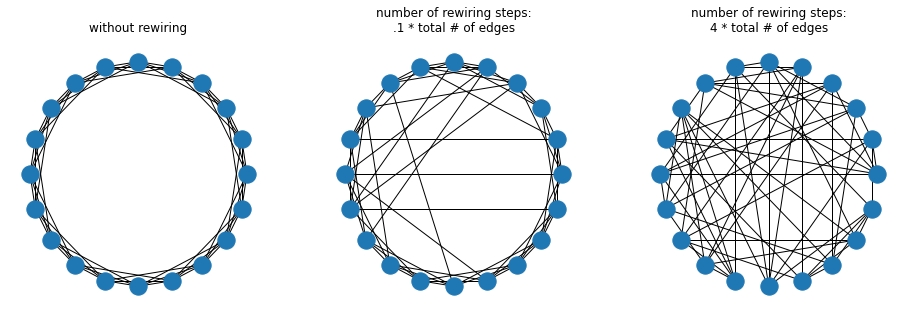

In [5]:
# example small world networks
G1 = ds.generate_network("watts_strogatz_graph",n=20,k=6,p=0,ms_rewiring=0)
G2 = ds.generate_network("watts_strogatz_graph",n=20,k=6,p=0,ms_rewiring=.1)
G3 = ds.generate_network("watts_strogatz_graph",n=20,k=6,p=0,ms_rewiring=4)

plt.figure(figsize=[16,5])
plt.subplot(131, title='without rewiring')
nx.draw(G1, pos=nx.circular_layout(G1))
plt.subplot(132, title='number of rewiring steps:\n.1 * total # of edges')
nx.draw(G2, pos=nx.circular_layout(G2))
plt.subplot(133, title='number of rewiring steps:\n4 * total # of edges')
nx.draw(G3, pos=nx.circular_layout(G3))

plt.show()

## Simulation run

Now that we've discussed what the agents and their connections look like, it's time to discuss the steps that the agents will take to exchange information or influence eachother. In a simulation run, this is called the *simulation stage*. We model time as a series of discrete events: at every 'timestep', some interaction event happens. Typically, we pick an agent, pick the agent's neighbor(s), let them influence (eachother), and update their dissimilarity value. Sometimes, events may be added to this sequence to represent some process of interest (like the influence of bots or mass media, or things like network rewiring). A simulation run in defSim can be created with the function `Simulation` or by defining your own simulation function with `def Sim():`.

To test the effect of the bots on the diffusion of a piece of information, we create a simple model with 1 bot agent who is connected to a given proportion of the network. The agents follow a homophily-based assimilative influence rule, as in Axelrod (1997). The bot is never influenced. We model a situation in which three topics are discussed, and give the bot a fixed trait of '99' on feature 1, a trait that no other agent has. All occurrences of 99 in the final graph must stem from the bot agent.

Here, we focus on the effect of two different parameters: their connectedness (to what proportion of agents are the bots connected) and their activation rate (how often are the bots trying to influence their neighbors).

In [6]:
def simulation_run(bot_connectedness=.25,
                   bot_activation_rate=.25,
                   N=80,
                   max_ticks=10000,
                   seed=None,
                   num_features = 3,
                   num_traits = 3,
                   ms_rewiring = 0):
    random.seed(seed)
    
    G = ds.generate_network("watts_strogatz_graph",n=N,k=6,p=0,ms_rewiring=ms_rewiring)
    ds.initialize_attributes(G, realization="random_categorical", num_features=num_features, num_traits=num_traits)
    
    # add the bot to the graph
    agentlist = list(G.nodes()) #Gives a list of notes created in the watts_strogatz graph
    G.add_node("bot") # Adding a bot
    # Defining feature distribution of the bot. 
    for i in np.arange(num_features + 1)[2:]:
        G.nodes["bot"]["f01"] = 99
        G.nodes["bot"]["f0"+str(i)] = 0
    
    friends_of_bot = random.sample(agentlist, int(bot_connectedness * N))
    
    for j in friends_of_bot:
        G.add_edge("bot",j)
    
    calculator = ds.dissimilarity_calculator.select_calculator("hamming")
    calculator.calculate_dissimilarity_networkwide(G)

    ticks = 0
    stop = False
    bot_trait_count = []

    while(not stop):
        ticks += 1

        if random.random() > bot_activation_rate:
            agent_i = ds.select_focal_agent(G,"random",agentlist=agentlist)
        else:
            agent_i = "bot"
            
        agent_j = ["bot"]
        while agent_j == ["bot"]:
            agent_j = [(random.choice([neighbor for neighbor in G[agent_i]]))]

        ds.influence_sim.spread_influence(G,"axelrod",agent_i,agent_j,"one-to-one",calculator)
        bot_trait_count.append(list(nx.get_node_attributes(G,'f01').values()).count(99))

        # stop condition
        if(not any([True for i,j,d in G.edges.data('dist') if 0.1 < d < .9])
           or ticks >= max_ticks):
            return bot_trait_count
            stop = True

## A closer look at the simulation run

To understand what is going on during the simulation it is a good idea to inspect the run further. For example, print all opinions at every timepoint during a simulation run, or create simple tests to inspect model behavior under different conditions. These tests can help understand if what you suspect is happening actually happens in the model. This will help you understand what the mechanism is all about that is at play in your model.

In [ ]:
a = simulation_run(bot_activation_rate=0.5, bot_connectedness=0.5, num_features= 3, num_traits= 3, N=100, seed=66)
b = simulation_run(bot_activation_rate=0.5, bot_connectedness=0.5, num_features= 3, num_traits= 3, N=100, seed=66)

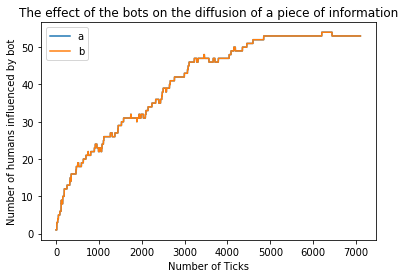

In [ ]:
plt.plot(a)
plt.plot(b)
plt.xlabel("Number of Ticks")
plt.ylabel("Number of humans influenced by bot")
plt.title("The effect of the bots on the diffusion of a piece of information")
plt.legend(['a','b'], loc="upper left")

## Simulation experiment

Now that we have some intuitions about what is happening in the model, it's time to put our intuitions to the test. We can do so by running a simulation experiment: a series of independent simulation runs, to estimate some general outcome in equilibrium. We can compare averages of outcome variables of interest (like for example, average opinion difference between connected agents to represent polarization) over a large set of simulation runs, between certain conditions. Just like in emprical research, a single observation might give you an indication, or provide anecdotal evidence, but an experiment can provide you with robust estimates. A simulation experiment in defSim can be created with the function `Experiment` or by defining your own experiment, in which you repeatedly call your simulation function.

In [7]:
def experiment(bot_connectedness=[.1,.3,.5,.7,.9],
               bot_activation_rate=[.1,.9],
               replications=20):
    parameter_combinations = []
    parameter_combinations.append([(connected,activation) for connected in bot_connectedness for activation in bot_activation_rate])
    parameter_combinations = [x * replications for x in parameter_combinations]
    
    results = []
    
    ticker = 0
    for connected,activation in parameter_combinations[0]:
        run_result = {'bot_connectedness':connected,
                       'bot_activation_rate':activation,
                       'diffusion_bot_belief':simulation_run(bot_connectedness=connected,bot_activation_rate=activation)[-1]}
        results.append(run_result)
        ticker += 1
        
    return pd.DataFrame(results)
    #print(parameter_combinations)

In [8]:
results = experiment(bot_connectedness=[.1,.9], bot_activation_rate=[.1])

/usr/local/lib/python3.7/dist-packages/defSim/influence_sim/SimilarityAdoption.py:42: UserWarning: homophily not specified, using default value 1
  warnings.warn("homophily not specified, using default value 1")


ValueError: ignored

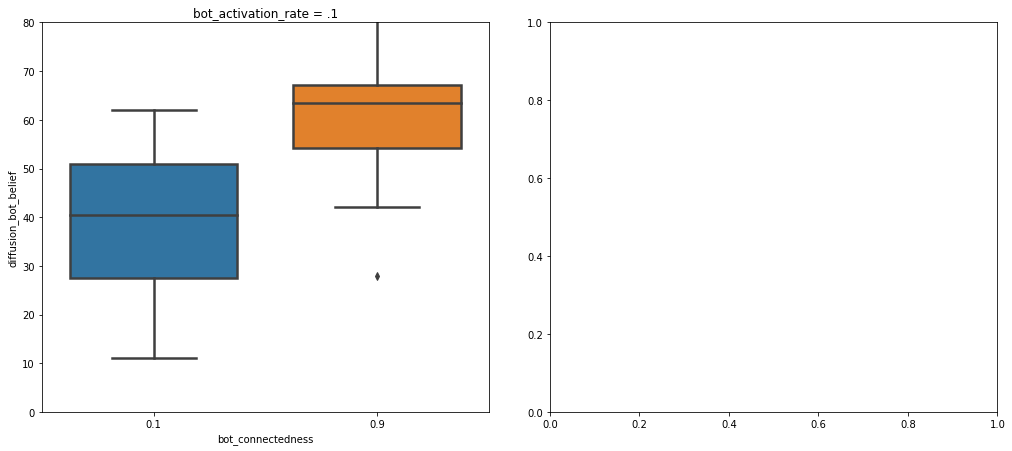

In [11]:
df1 = results[['bot_connectedness','diffusion_bot_belief']].loc[results['bot_activation_rate']==.1]
df2 = results[['bot_connectedness','diffusion_bot_belief']].loc[results['bot_activation_rate']==.9]

fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(w_pad=3)
#font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
#plt.rc('font', **font)

p1 = sns.boxplot(y='diffusion_bot_belief', x='bot_connectedness', data=df1, width=0.75, ax=ax[0], linewidth=2.5)
p1.set_ylim([0,80])
p1.set_title('bot_activation_rate = .1')

p2 = sns.boxplot(y='diffusion_bot_belief', x='bot_connectedness', data=df2, width=0.75, ax=ax[1], linewidth=2.5)
p2.set_ylim([0,80])
p2.set_title('bot_activation_rate = .9')

fig.show()

---

## Now it's up to you

We gave you a head start with this example code. Now it is up to you to build your own experiment to answer your research question. Some good next steps would be:

1. **Summarize your model in pseudo-code** - write down all the steps, from initialization, to simulation and convergence rule. This helps you to understand what is going on in the model, but mostly helps you check your reasoning about the model dynamics.
2. **Identify the way in which your model should be changed, or what needs to be done before your experiment**
3. **Execute a literature search for similar models** - the literature is rich, and there may be models that have a very similar implementation (alignment) or that have a different implementation, but describe mechanisms that are the same (docking).
4. **Think about your experiment** - What conditions will you test against eachother? And what variable will you measure as your main outcome?

---

In [ ]:
# your code

# All human nodes start with 0 opinion 
#### Notes about attributes:
#num_of_bots is the number of bots in sim
#bot_dom_feat (defined as a list) lets you pick the dominant feature of each bot. The lengths of the list is equal to num_of_bots
#feature_focus tells us which feature the graph focuses on when looking at the polarization of nodes 
# (see example code below how it can be used to see the polarization acroos different features)
def simulation_run(bot_connectedness=.25,
                   bot_activation_rate=.25,
                   N=80,
                   max_ticks=10000,
                   num_of_bots = 2,
                   bot_dom_feat = [1, 1],
                   num_features = 3,
                   num_traits = 3,
                   feature_focus = 'f01',
                   ms_rewiring = 0,
                   seed=None):
    random.seed(seed)
    
    G = ds.generate_network("watts_strogatz_graph",n=N,k=6,p=0,ms_rewiring=ms_rewiring)
    ds.initialize_attributes(G, realization="random_categorical", num_features=num_features, num_traits=num_traits)
    
    # add the bot to the graph
    agentlist = list(G.nodes()) #Gives a list of notes created in the watts_strogatz graph
    friends_of_bots = np.empty((num_of_bots, int(bot_connectedness * N)), dtype=int)
    for i in np.arange(num_of_bots + 1)[1:]:
        G.add_node("bot" + str(i))
        friends_of_bots[i-1, :] = random.sample(agentlist, int(bot_connectedness * N))
        for j in np.arange(num_features + 1)[1:]:
            G.nodes["bot" + str(i)]["f0" + str(j)] = 0  
        G.nodes["bot" + str(i)]["f0" + str(bot_dom_feat[i-1])] = 99
        for f in friends_of_bots[i-1, :]:
            G.add_edge("bot"+str(i), f) 
    
    # Defining friends of the bot. The friends are randomly sampled from the list of agents (nodes) excluding the bots. 
    # The number of such "friends" is controlled by "bot_connectedness" & N (the number of nodes [i.e. non-bots])
    
    #Now, we make the connection between bots and their friends. This is defined by a edge in the watts_strogatz graph.
    
    calculator = ds.dissimilarity_calculator.select_calculator("hamming")
    # the Hamming distance between two variables (or nodes) of equal length is the number of positions at which the corresponding symbols are different. 
    calculator.calculate_dissimilarity_networkwide(G) 

    ticks = 0
    stop = False
    bot_trait_count = []

    while(not stop):
        ticks += 1
        x = str(np.random.choice(np.arange(num_of_bots + 1)[1:], 1)[0])
        if random.random() > bot_activation_rate: 
            agent_i = ds.select_focal_agent(G,"random",agentlist=agentlist) #the focal agent is who sends their attribute value
        else:
            agent_i = "bot" + x
            
        agent_j = ["bot"+ x]
        while agent_j == ["bot" + x]:
            agent_j = [(random.choice([neighbor for neighbor in G[agent_i]]))]

        ds.influence_sim.spread_influence(G,"axelrod",agent_i,agent_j,"one-to-one",calculator)
        bot_trait_count.append(list(nx.get_node_attributes(G,feature_focus).values()).count(99))

        # stop condition
        if(not any([True for i,j,d in G.edges.data('dist') if 0.1 < d < .9])
           or ticks >= max_ticks):
            return bot_trait_count
            stop = True

In [ ]:
test = simulation_run(num_of_bots=3, bot_dom_trait=[2, 1, 1], feature_focus='f01', seed = 99)
test2 = simulation_run(num_of_bots=3, bot_dom_trait=[2, 1, 1], feature_focus='f02', seed = 99)
test3 = simulation_run(num_of_bots=3, bot_dom_trait=[2, 1, 1], feature_focus='f03', seed = 99)

In [ ]:
plt.plot(test)
plt.plot(test2)
plt.plot(test3)
plt.legend([1,2,3])

---

### References
